In [1]:
using MatrixNetworks
using Distributions
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra
using Plots
using SphericalGraphEmbedding

### Compute NMI between retreived and true community


========== Graph 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 252 iterations
  1.969718 seconds (28.93 k allocations: 1.709 GiB, 10.72% gc time, 1.74% compilation time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 16
Number of communities: 37
Modularity: 0.7410925899861573
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.4009825807998712, 0.2680194636976883, 0.17785201151974406, 0.09650187369579871, 0.056170532949252845]
 -------------------------------------------- 
  4.135757 seconds (1.30 M allocations: 2.094 GiB, 6.42% gc time, 12.92% compilation time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 320 iterations
  2.436332 seconds (8.68 k allocations: 2.170 GiB, 10.01% gc time)
 -------------- Clustering ---

[0.20849196629273095, 0.19089827223049868, 0.13969333194633823, 0.10804023307977764, 0.09695111315327071]
 -------------------------------------------- 
  3.325623 seconds (344.11 k allocations: 1.784 GiB, 5.17% gc time)

========== Graph 6/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 259 iterations
  1.878764 seconds (7.04 k allocations: 1.755 GiB, 8.99% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 14
Number of communities: 40
Modularity: 0.16346090476399922
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.17601716770773046, 0.1573957493869535, 0.1364874829182031, 0.1268287316183165, 0.09962903046683667]
 -------------------------------------------- 
  3.781230 seconds (376.99 k allocations: 2.152 GiB, 5.34% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power I

dimension of embedding used for clustering: 100
Number of updates: 13
Number of communities: 41
Modularity: 0.14513216901611828
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.15658136188312394, 0.14775899871954964, 0.1350138339328984, 0.10961956651471132, 0.09650561354531045]
 -------------------------------------------- 
  4.937235 seconds (362.38 k allocations: 2.150 GiB, 5.22% gc time)


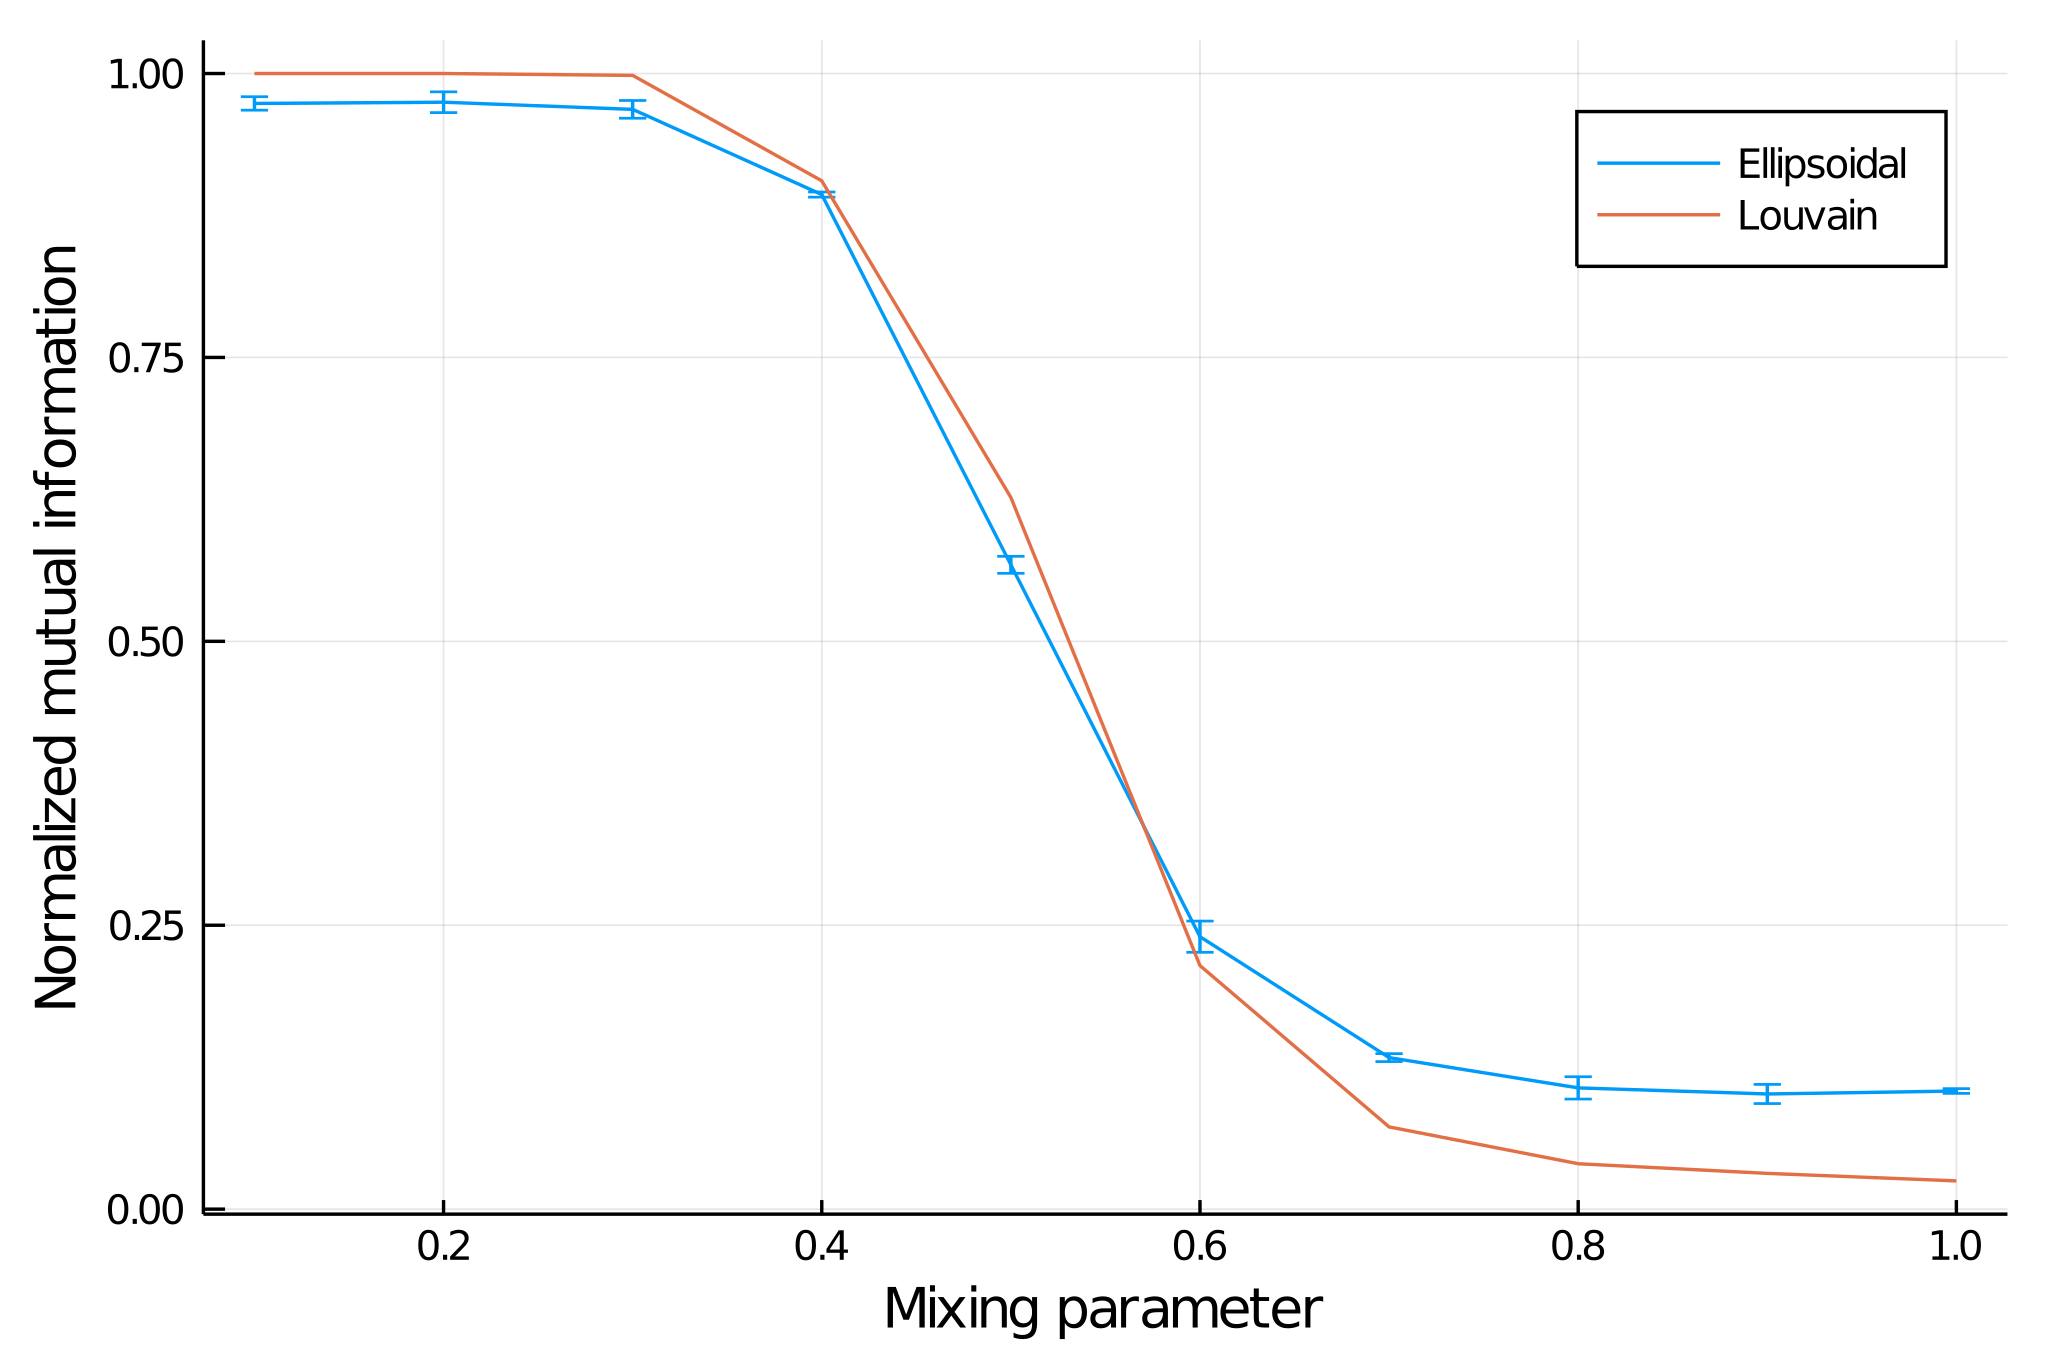

In [2]:
## Compute NMI for each graph

path="LFR_data/"
n_graphs=10

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
r0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
mus=zeros(Float64,n_graphs)
NMIs=zeros(Float64,n_graphs,n_rep)
NMIs_louvain=zeros(Float64,n_graphs)

for g=1:n_graphs
    println("\n========== Graph $g/$(n_graphs) ==========")
    
    # load communities
    community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)
    community_louvain=readdlm(path*"louvain_communities"*string(g-1)*".txt",Int)

    # load graph
    edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

    n_nodes=size(community_true)[1]
    n_edges=size(edgeList)[1]

    # construct sparse adjacency matrix from list of edges
    adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
    adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

    # keep only the largest connected component
    adj,vertices = largest_component(adj);
    
    community_true=community_true[vertices]
    community_true=rename_com_unique(community_true)
    
    community_louvain=community_louvain[vertices]
    community_louvain=rename_com_unique(community_louvain)

    # load parameters
    LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
    mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
    mus[g]=mu
    
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")
        
        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0)

        NMIs[g,j]=mutualinfo(community_true,community);
    end
    NMIs_louvain[g]=mutualinfo(community_true,community_louvain);
end

#######################################################################
# Plot Normalized mutual information vs Miwing parameter
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(mus, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

plot!(mus, NMIs_louvain,
markerstrokecolor=:auto,
xlabel = "Mixing parameter",
ylabel = "Normalized mutual information",
labels = "Louvain")
savefig("./nmi_vs_mu.pdf")
plot!()
#######################################################################

### Test impact of r0

mu=0.4
========== r0 step 1/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 217 iterations
  0.251846 seconds (5.69 k allocations: 152.193 MiB, 14.98% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 2
Number of communities: 15
Modularity: 0.37342125830609946
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22037495889888875, 0.212853338134903, 0.18146591424701938, 0.12869036935989525, 0.09848531496302132]
 -------------------------------------------- 
  0.381132 seconds (109.72 k allocations: 218.985 MiB, 13.18% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 222 iterations
  0.234809 seconds (5.82 k allocations: 155.711 MiB, 12.35% gc time)
 -------------- Clustering ------- 
dimension of embedding used f

[0.2201576118950791, 0.2131288924702443, 0.18106124004166935, 0.12812872108592213, 0.09905866730579467]
 -------------------------------------------- 
  0.918157 seconds (151.87 k allocations: 590.275 MiB, 7.60% gc time)

========== r0 step 6/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 313 iterations
  1.276947 seconds (8.18 k allocations: 758.468 MiB, 7.87% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 35
Number of updates: 6
Number of communities: 21
Modularity: 0.3885579682430489
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22004413750190116, 0.21296684128867407, 0.18111591789858597, 0.1280561121178065, 0.09906514053165492]
 -------------------------------------------- 
  1.688016 seconds (197.59 k allocations: 902.620 MiB, 6.59% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Po

dimension of embedding used for clustering: 55
Number of updates: 5
Number of communities: 31
Modularity: 0.3854737326295851
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22007572107059542, 0.21291623241519025, 0.18104366082054998, 0.12829019632610086, 0.09904409080688745]
 -------------------------------------------- 
  1.563862 seconds (209.96 k allocations: 990.173 MiB, 6.49% gc time)

========== r0 step 11/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 267 iterations
  1.351124 seconds (7.25 k allocations: 1.083 GiB, 8.36% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 60
Number of updates: 6
Number of communities: 30
Modularity: 0.3859892279227714
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21987116084685612, 0.21292996019385266, 0.180934579

The iteration has become stationary after 269 iterations
  1.435099 seconds (7.41 k allocations: 1.456 GiB, 8.61% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 80
Number of updates: 7
Number of communities: 30
Modularity: 0.3854382697301941
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.2198801839975732, 0.21292992703811894, 0.1809433865113597, 0.12814471733682842, 0.09914948245750078]
 -------------------------------------------- 
  2.421566 seconds (274.11 k allocations: 1.716 GiB, 5.63% gc time)

========== r0 step 16/19 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 285 iterations
  1.642464 seconds (7.74 k allocations: 1.640 GiB, 8.80% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 85
Number of updates: 10
Number of communities: 35
Modularity: 0.38237351697553

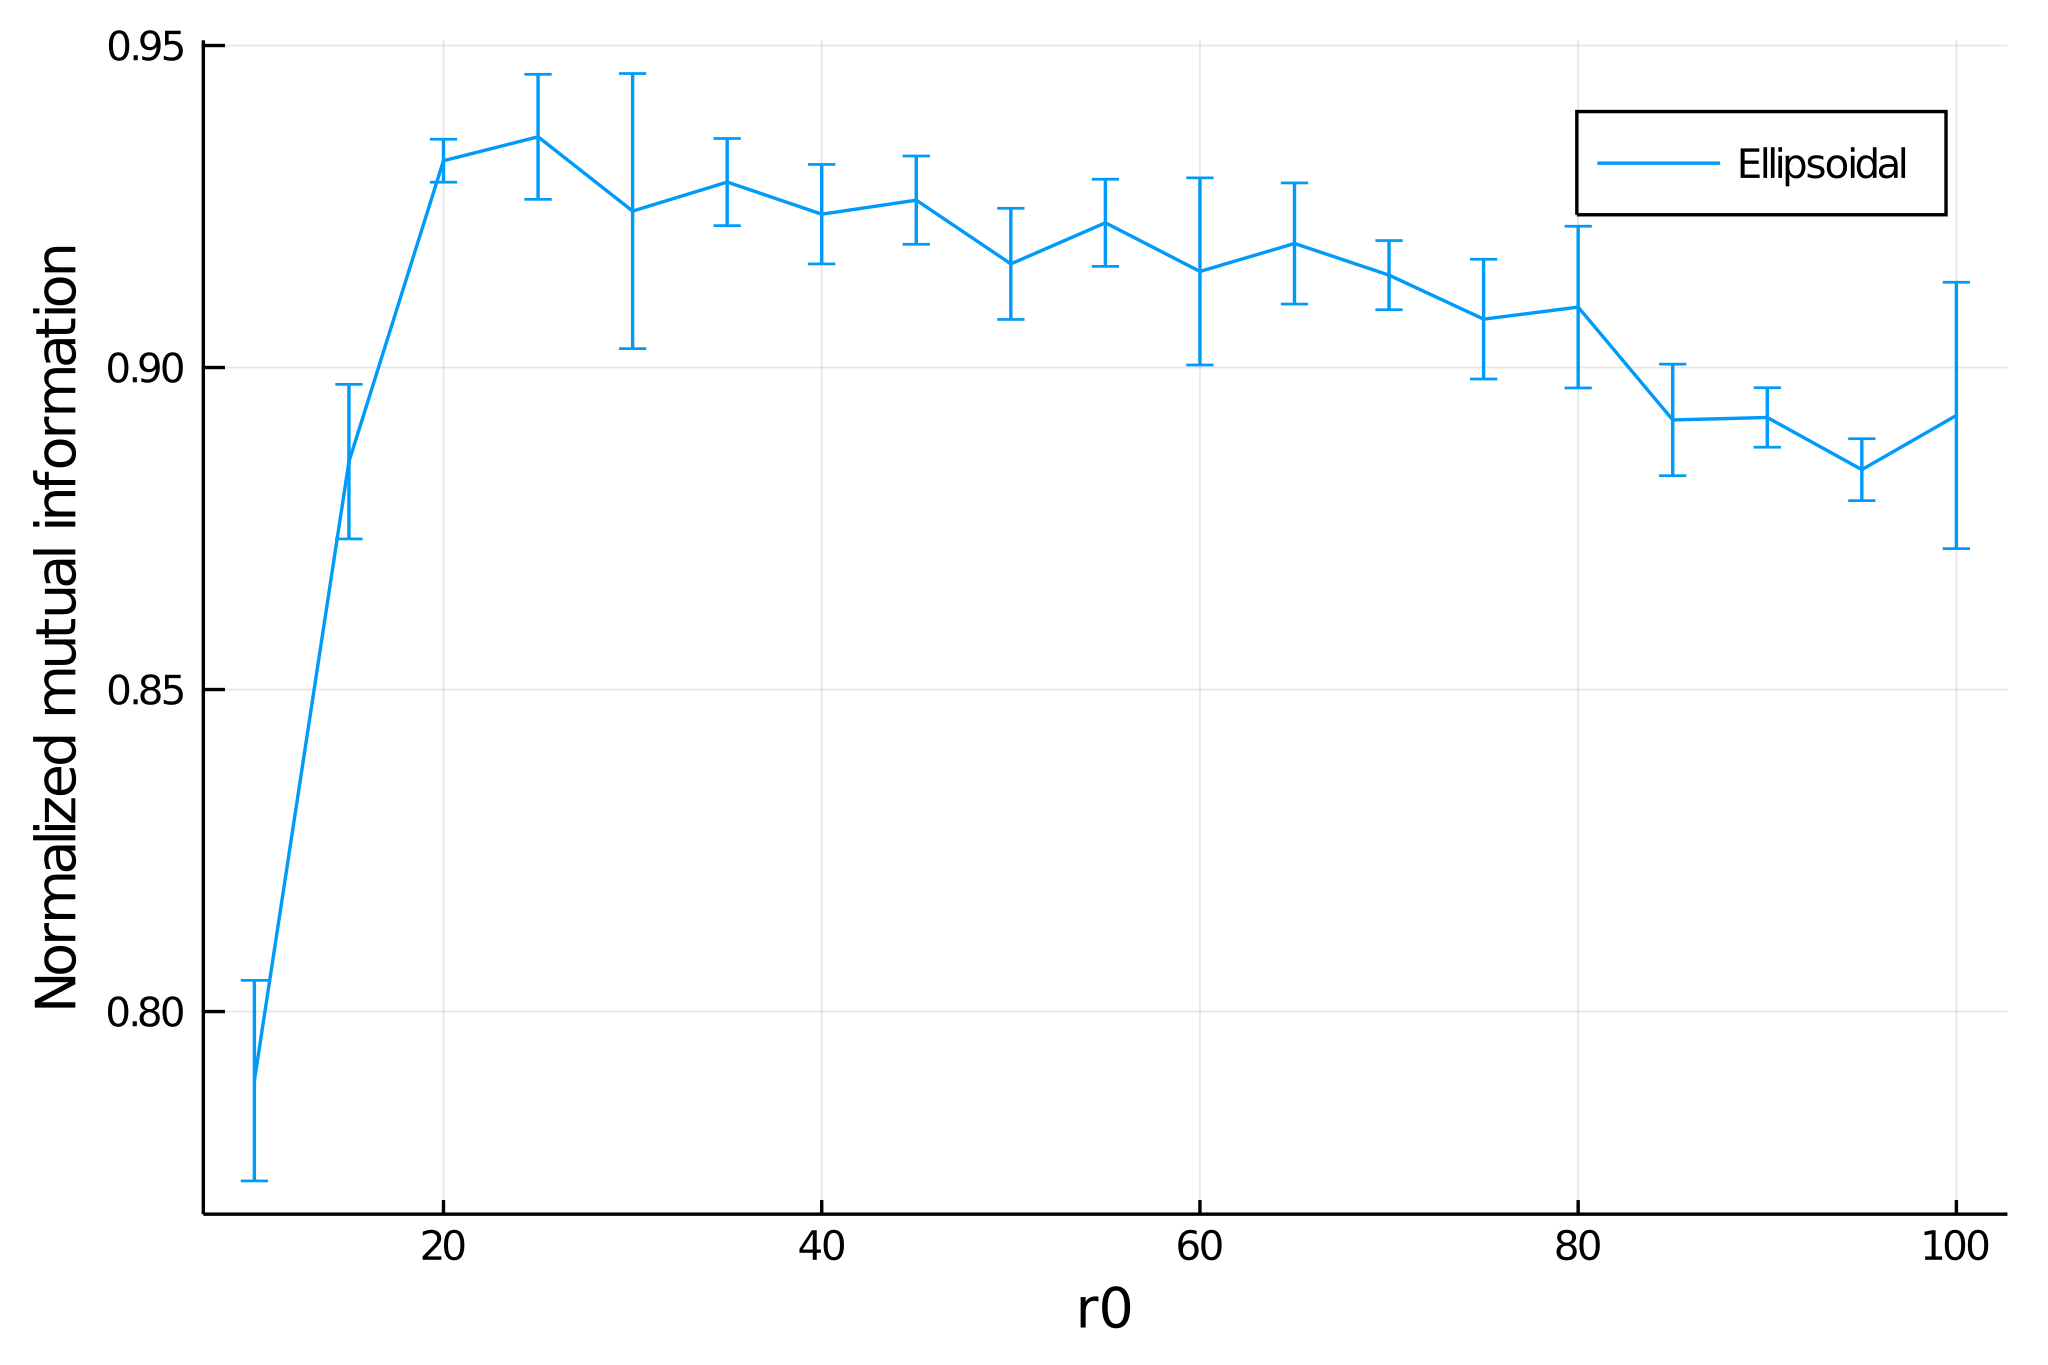

In [3]:
g=4

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
r0s = 10:5:100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(r0s),n_rep)

# load communities
community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes=size(community_true)[1]
n_edges=size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true=community_true[vertices]
community_true=rename_com_unique(community_true)

# load parameters
LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(r0s)
    println("\n========== r0 step $i/$(length(r0s)) ==========")
    r0=r0s[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0)

        NMIs[i,j]=mutualinfo(community_true,community);
    end
end

#######################################################################
# Plot Normalized mutual information vs r0
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(r0s, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "r0",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

savefig("./nmi_vs_r0__mu"*string(mu)*".pdf")
plot!()
#######################################################################

### Test impact of n_clusters

mu=0.4
========== n_clusters step 1/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 268 iterations
  1.980412 seconds (7.28 k allocations: 1.816 GiB, 9.86% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 13
Number of communities: 10
Modularity: 0.3437943633702726
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.21983473831591907, 0.2128890436757898, 0.1809708105506277, 0.12817401420288813, 0.09912164367047166]
 -------------------------------------------- 
  2.282214 seconds (365.02 k allocations: 2.032 GiB, 9.46% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 268 iterations
  1.914502 seconds (7.28 k allocations: 1.816 GiB, 9.63% gc time)
 -------------- Clustering ------- 
dimension of embedding used f

[0.22000996258044136, 0.2129319611606859, 0.18107603188473467, 0.12813667695178654, 0.0990706981245058]
 -------------------------------------------- 
  2.879273 seconds (287.53 k allocations: 2.352 GiB, 7.51% gc time)

========== n_clusters step 6/10 ==========

  ~~~~~ number_rep = 1/3 ~~~~~
 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 232 iterations
  1.616519 seconds (6.31 k allocations: 1.572 GiB, 9.55% gc time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 100
Number of updates: 9
Number of communities: 37
Modularity: 0.37701451861300206
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22013614793167208, 0.21311198753628935, 0.18105813633459983, 0.12811256781882926, 0.09911742555194866]
 -------------------------------------------- 
  2.446442 seconds (273.05 k allocations: 1.807 GiB, 7.10% gc time)

  ~~~~~ number_rep = 2/3 ~~~~~
 ------- Acc Project

dimension of embedding used for clustering: 100
Number of updates: 9
Number of communities: 42
Modularity: 0.37444752552185534
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.22004010062130955, 0.21291016968499832, 0.1810730288196275, 0.12811370624510568, 0.09908323624047535]
 -------------------------------------------- 
  3.288008 seconds (263.58 k allocations: 2.389 GiB, 6.10% gc time)


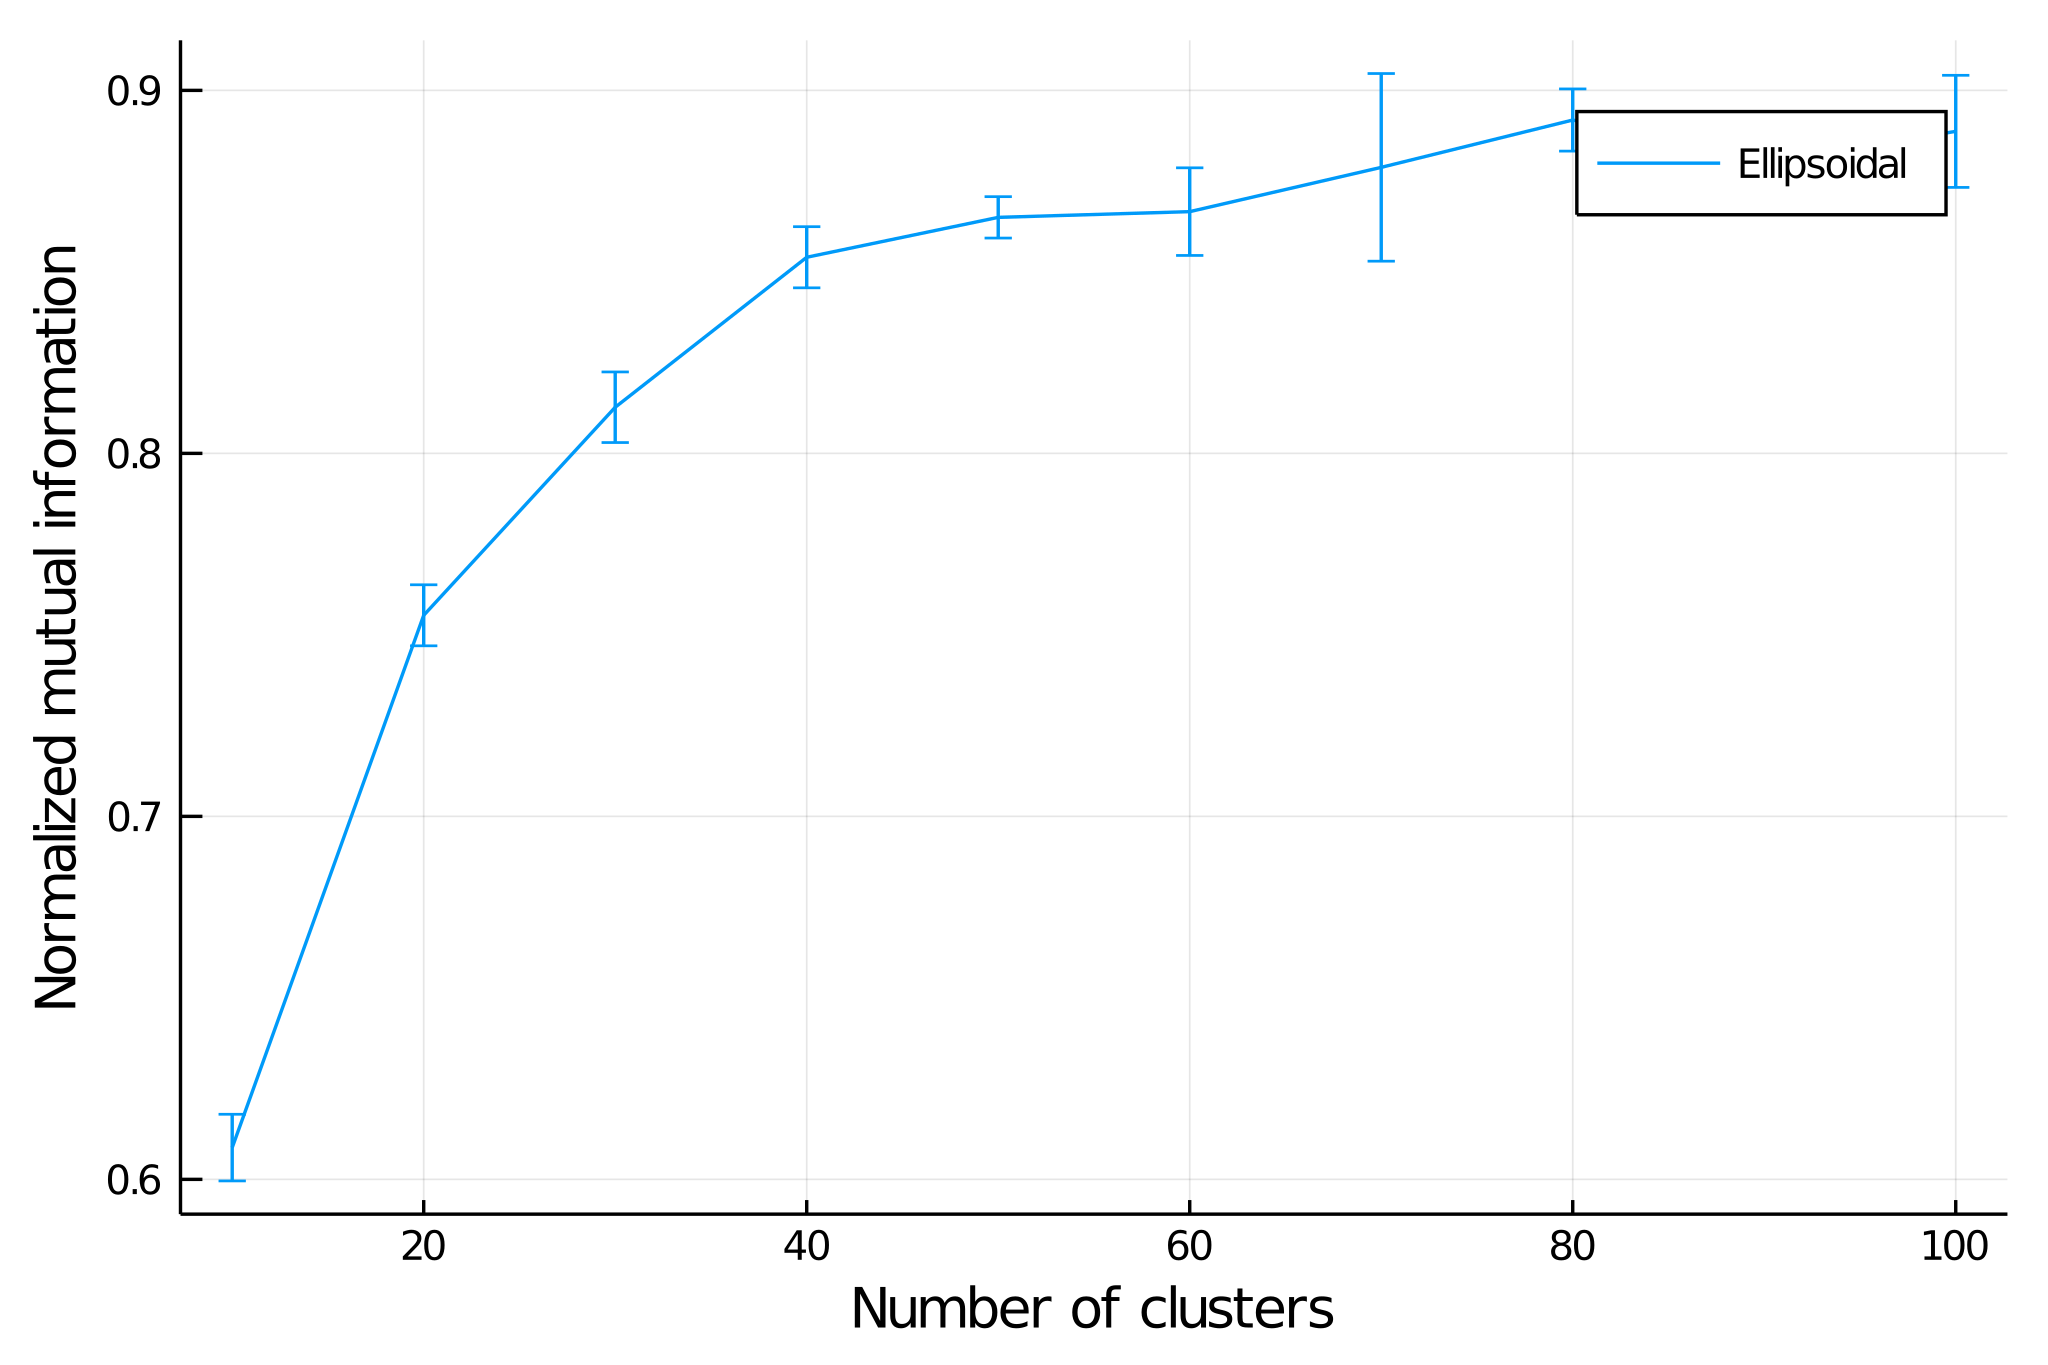

In [4]:
g=4

# Set parameters of simulations

n_it_PPM = 30000;
t = 1e-10;
n_clusters_list = 10:10:100;
r0 = 100;

# Specify here the number of times vector partition is repeated
n_it_Vec_Partition = 10;
# we advise : n_it_Vec_Partition = 100;

n_updates = 100; # max total by default
shape = "Ellipsoidal"; #shape = "Spherical"

n_rep = 3;
NMIs=zeros(Float64,length(n_clusters_list),n_rep)

# load communities
community_true=readdlm(path*"communities"*string(g-1)*".txt",Int)

# load graph
edgeList=readdlm(path*"edgeList"*string(g-1)*".txt",Int)

n_nodes=size(community_true)[1]
n_edges=size(edgeList)[1]

# construct sparse adjacency matrix from list of edges
adj=sparse(edgeList[:,1].+1,edgeList[:,2].+1,vec(ones(Int64,n_edges,1)),n_nodes,n_nodes)
adj=adj+adj' # only the upper triangular part of adjacency matrix was stored

# keep only the largest connected component
adj,vertices = largest_component(adj);

community_true=community_true[vertices]
community_true=rename_com_unique(community_true)

# load parameters
LFR_parameters=readdlm(path*"parameters"*string(g-1)*".txt")
mu=parse(Float64, split(LFR_parameters[4],"=")[2]) # extract mixing marameter (not very robust)
print("mu=$mu")

for i=1:length(n_clusters_list)
    println("\n========== n_clusters step $i/$(length(n_clusters_list)) ==========")
    n_clusters=n_clusters_list[i]
    for j=1:n_rep
        println("\n  ~~~~~ number_rep = $j/$(n_rep) ~~~~~")

        # embed cluster
        _,community = @time sphere_embed_cluster(adj,n_it_PPM,t, n_clusters,n_it_Vec_Partition,n_updates,shape,r0)

        NMIs[i,j]=mutualinfo(community_true,community);
    end
end

#######################################################################
# Plot Normalized mutual information vs r0
#######################################################################
m = mean(NMIs,dims=2);
s = std(NMIs,dims=2);
plot(n_clusters_list, m, yerror = s,
markerstrokecolor=:auto,
xlabel = "Number of clusters",
ylabel = "Normalized mutual information",
labels = "Ellipsoidal")

savefig("./nmi_vs_nclusters__mu"*string(mu)*".pdf")
plot!()
#######################################################################